Hopefully this notebook is now a working example of the multinomial player model.

In [1]:
import os

import pandas as pd

import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt


Get a sample of player data.  Just look at forwards, with data up to the middle of the 2019/20 season.

In [2]:
from airsenal.framework.prediction_utils import process_player_data
from airsenal.framework.utils import get_player

In [15]:
def get_player_data(position, season="1920", latest_gameweek=38):
    data = process_player_data(position, season, latest_gameweek)
    return data

In [16]:
data = get_player_data("FWD")

Filling history dataframe for Sergio Agüero: 0/87 done
Filling history dataframe for Pierre-Emerick Aubameyang: 1/87 done
Filling history dataframe for Harry Kane: 2/87 done
Filling history dataframe for Jamie Vardy: 3/87 done
Filling history dataframe for Gabriel Fernando de Jesus: 4/87 done
Filling history dataframe for Roberto Firmino: 5/87 done
Filling history dataframe for Alexandre Lacazette: 6/87 done
Filling history dataframe for Marcus Rashford: 7/87 done
Filling history dataframe for Romelu Lukaku: 8/87 done
Filling history dataframe for Raúl Jiménez: 9/87 done
Filling history dataframe for Tammy Abraham: 10/87 done
Filling history dataframe for Callum Wilson: 11/87 done
Filling history dataframe for Danny Ings: 12/87 done
Filling history dataframe for Marko Arnautovic: 13/87 done
Filling history dataframe for Sébastien Haller: 14/87 done
Filling history dataframe for Olivier Giroud: 15/87 done
Filling history dataframe for Michy Batshuayi: 16/87 done
Filling history datafram

this gives us a dict with keys:
```
"player_ids" (list of ints),
"nplayer" (int), 
"nmatch" (int), 
"minutes" (numpy array with shape (nplayer, nmatch)), 
"y" (numpy array with shape (nplayer, nmatch, 3)), 
"alpha" (numpy array with shape (3,))
```


### numpyro model

The below took a lot of iterations to figure out how to broadcast over the right dimensions.
Hopefully it's sort-of right...


In [18]:
def model(nplayer, nmatch, minutes, y, alpha):
    theta = dist.Dirichlet(concentration=alpha)
    # one sample from the prior per player
    with numpyro.plate("nplayer", nplayer) as player_index:
        dprobs = numpyro.sample("probs", theta) 
    # now it's all about how to broadcast in the right dimensions.....
    prob_score = numpyro.deterministic("prob_score",dprobs[:,0,None] * (minutes / 90.))
    prob_assist = numpyro.deterministic("prob_assist",dprobs[:,1,None] * (minutes / 90.))
    prob_neither = numpyro.deterministic("prob_neither",dprobs[:,2,None] * (minutes / 90.) + (90. - minutes))
    theta_mins = dist.Multinomial(
                probs=jnp.moveaxis(jnp.array([prob_score, prob_assist, prob_neither]),0,2)
    )
    return numpyro.sample("obs", theta_mins, obs=y)

In [19]:
def fit_model(data, model):
    kernel = NUTS(model)
    mcmc = MCMC(
    kernel,
    num_warmup=1500,
    num_samples=3000,
    num_chains=1,
    progress_bar=True
    )
    rng_key, rng_key_predict = random.split(random.PRNGKey(44))
    mcmc.run(rng_key,
         data["nplayer"],
         data["nmatch"],
         data["minutes"],
         data["y"],
         data["alpha"]
    )
    return mcmc.get_samples()

In [20]:
def get_probs(player_index, samples):
    prob_score = float(samples["probs"][:,player_index,0].mean())
    prob_assist = float(samples["probs"][:,player_index,1].mean())
    prob_neither = float(samples["probs"][:,player_index,2].mean())
    return (prob_score, prob_assist, prob_neither)

In [27]:
def create_dataframe(names, samples):
    prob_dict = {"name":[],"prob_score": [], "prob_assist": [], "prob_neither": []}
    for i, pid in enumerate(names):
        pid = int(pid)
        prob_dict["name"].append(get_player(pid).name)
        probs = get_probs(i, samples)
        prob_dict["prob_score"].append(probs[0])
        prob_dict["prob_assist"].append(probs[1])
        prob_dict["prob_neither"].append(probs[2])
    df = pd.DataFrame(prob_dict)
    return df

In [28]:
def run_model(position="FWD",season="1920",latest_gameweek=38):
    data = get_player_data(position, season, latest_gameweek)
    samples = fit_model(data, model)
    df = create_dataframe(data["player_ids"], samples)
    return df

Now go through the whole chain for each position in turn

In [29]:
df_fwd = run_model("FWD")
df_mid = run_model("MID")
df_def = run_model("DEF")

Filling history dataframe for Sergio Agüero: 0/87 done
Filling history dataframe for Pierre-Emerick Aubameyang: 1/87 done
Filling history dataframe for Harry Kane: 2/87 done
Filling history dataframe for Jamie Vardy: 3/87 done
Filling history dataframe for Gabriel Fernando de Jesus: 4/87 done
Filling history dataframe for Roberto Firmino: 5/87 done
Filling history dataframe for Alexandre Lacazette: 6/87 done
Filling history dataframe for Marcus Rashford: 7/87 done
Filling history dataframe for Romelu Lukaku: 8/87 done
Filling history dataframe for Raúl Jiménez: 9/87 done
Filling history dataframe for Tammy Abraham: 10/87 done
Filling history dataframe for Callum Wilson: 11/87 done
Filling history dataframe for Danny Ings: 12/87 done
Filling history dataframe for Marko Arnautovic: 13/87 done
Filling history dataframe for Sébastien Haller: 14/87 done
Filling history dataframe for Olivier Giroud: 15/87 done
Filling history dataframe for Michy Batshuayi: 16/87 done
Filling history datafram

sample: 100%|████████████████████████████████| 4500/4500 [00:14<00:00, 319.03it/s, 15 steps of size 3.74e-01. acc. prob=0.87]


Filling history dataframe for Mohamed Salah: 0/264 done
Filling history dataframe for Sadio Mané: 1/264 done
Filling history dataframe for Raheem Sterling: 2/264 done
Filling history dataframe for Kevin De Bruyne: 3/264 done
Filling history dataframe for Heung-Min Son: 4/264 done
Filling history dataframe for Nicolas Pépé: 5/264 done
Filling history dataframe for Leroy Sané: 6/264 done
Filling history dataframe for Bruno Miguel Borges Fernandes: 7/264 done
Filling history dataframe for Christian Eriksen: 8/264 done
Filling history dataframe for Riyad Mahrez: 9/264 done
Filling history dataframe for Bamidele Alli: 10/264 done
Filling history dataframe for Richarlison de Andrade: 11/264 done
Filling history dataframe for Paul Pogba: 12/264 done
Filling history dataframe for Anthony Martial: 13/264 done
Filling history dataframe for Bernardo Mota Veiga de Carvalho e Silva: 14/264 done
Filling history dataframe for James Maddison: 15/264 done
Filling history dataframe for Steven Bergwijn: 

Filling history dataframe for Douglas Luiz Soares de Paulo: 231/264 done
Filling history dataframe for Nathan Holland: 232/264 done
Filling history dataframe for Mihai-Alexandru Dobre: 233/264 done
Filling history dataframe for Marvelous Nakamba: 234/264 done
Filling history dataframe for Morgan Schneiderlin: 235/264 done
Filling history dataframe for Daniel Drinkwater: 236/264 done
Filling history dataframe for Dale Stephens: 237/264 done
Filling history dataframe for Callum Slattery: 238/264 done
Filling history dataframe for Tyreke Johnson: 239/264 done
Filling history dataframe for Ethan Ampadu: 240/264 done
Filling history dataframe for Jack Colback: 241/264 done
Filling history dataframe for Carlos Sánchez: 242/264 done
Filling history dataframe for Moritz Leitner: 243/264 done
Filling history dataframe for Luke Dreher: 244/264 done
Filling history dataframe for Hamza Choudhury: 245/264 done
Filling history dataframe for Tahith Chong: 246/264 done
Filling history dataframe for Ma

sample: 100%|████████████████████████████████| 4500/4500 [00:30<00:00, 146.71it/s, 15 steps of size 2.82e-01. acc. prob=0.86]


Filling history dataframe for Trent Alexander-Arnold: 0/215 done
Filling history dataframe for Andrew Robertson: 1/215 done
Filling history dataframe for Virgil van Dijk: 2/215 done
Filling history dataframe for Aymeric Laporte: 3/215 done
Filling history dataframe for Ricardo Domingos Barbosa Pereira: 4/215 done
Filling history dataframe for Matt Doherty: 5/215 done
Filling history dataframe for Marcos Alonso: 6/215 done
Filling history dataframe for Antonio Rüdiger: 7/215 done
Filling history dataframe for César Azpilicueta: 8/215 done
Filling history dataframe for Lucas Digne: 9/215 done
Filling history dataframe for David Luiz Moreira Marinho: 10/215 done
Filling history dataframe for Patrick van Aanholt: 11/215 done
Filling history dataframe for Kyle Walker: 12/215 done
Filling history dataframe for Benjamin Mendy: 13/215 done
Filling history dataframe for Benjamin Chilwell: 14/215 done
Filling history dataframe for Héctor Bellerín: 15/215 done
Filling history dataframe for Kieran

  0%|                                                                                               | 0/4500 [00:00<?, ?it/s]

Alpha is [ 1.62627542  2.6862585  47.6827491 ]


sample: 100%|████████████████████████████████| 4500/4500 [00:26<00:00, 172.31it/s, 15 steps of size 2.57e-01. acc. prob=0.86]


Text(0, 0.5, 'P(assist)')

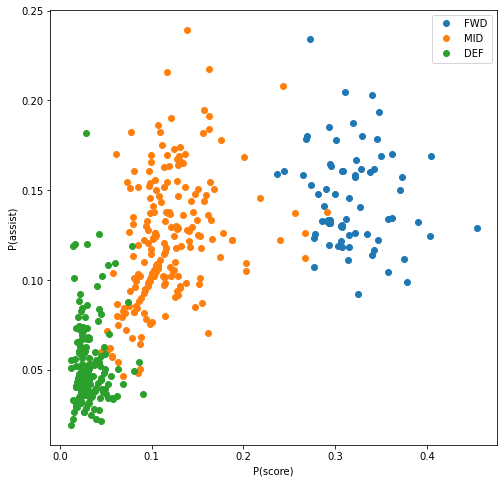

In [30]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8))
plt.plot(df_fwd['prob_score'], df_fwd['prob_assist'], 'o', label='FWD')
plt.plot(df_mid['prob_score'], df_mid['prob_assist'], 'o', label='MID')
plt.plot(df_def['prob_score'], df_def['prob_assist'], 'o', label='DEF')
plt.legend()
plt.xlabel('P(score)')
plt.ylabel('P(assist)')


In [31]:
df_fwd.sort_values(by='prob_score', ascending=False).head(10)

,name,prob_score,prob_assist,prob_neither
31,Danny Ings,0.454116,0.129237,0.416646
50,Sergio Agüero,0.404437,0.169283,0.426280
0,Pierre-Emerick Aubameyang,0.403909,0.124494,0.471597
18,Jamie Vardy,0.390709,0.132325,0.476966
43,Glenn Murray,0.378511,0.098740,0.522748
10,Chris Wood,0.375017,0.111557,0.513426
14,Tammy Abraham,0.372469,0.157403,0.470128
37,Andre Gray,0.371113,0.150416,0.478471
84,Javier Hernández Balcázar,0.361493,0.170029,0.468478
17,Dominic Calvert-Lewin,0.361457,0.134563,0.503980


In [32]:
df_mid.sort_values(by='prob_score', ascending=False).head(10)

,name,prob_score,prob_assist,prob_neither
87,Anthony Martial,0.291641,0.137793,0.570566
51,Richarlison de Andrade,0.267265,0.125991,0.606744
68,Sadio Mané,0.266684,0.112245,0.621070
70,Mohamed Salah,0.255693,0.137096,0.607211
117,Heung-Min Son,0.243224,0.207806,0.548970
59,Ayoze Pérez,0.239872,0.122262,0.637865
77,Raheem Sterling,0.217615,0.145721,0.636664
119,Lucas Rodrigues Moura da Silva,0.203099,0.109238,0.687663
171,Harry Wilson,0.202940,0.105086,0.691974
120,Bamidele Alli,0.200694,0.168622,0.630684
